## Imports

In [ ]:
import sys
import os

# To resolve import issues, add parent dir to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
import json
from game_board import Board
import modules.board_param as param
from plays._mcs import mcs_play
from plays._mcts import mcts_play
from itertools import permutations
from collections import defaultdict

## Definitions

### Game modes

In [ ]:
play_alg = {
    'Easy': lambda board : mcs_play(board, 100),
    'Medium': lambda board : mcs_play(board, 1000),
    'Hard': lambda board : mcts_play(board, 1000, 1.414),
}

### Function definitions

In [ ]:
def bot_vs_bot(mode1: str, mode2: str, verbose : int = 0, alg_dict: dict = play_alg):
    game_over = False
    board = Board()
    winner = 0
    turn = 0
    while not game_over:
        if turn == 0:
            opp_board = board.opposite_board()
            col = alg_dict[mode1](opp_board)
            game_over = board.play_turn(col, param.PLAYER_PIECE, display_board=False)
            if game_over:
                winner = mode1
        else:
            col = alg_dict[mode2](board)
            game_over = board.play_turn(col, param.BOT_PIECE, display_board=False)
            if game_over:
                winner = mode2

        if verbose >= 10:
            board.pretty_print_board()

        if len(board.get_valid_locations()) == 0 and not game_over:
            game_over = True
            winner = "Draw"
        turn ^= 1  # Switch turns
    
    if verbose:
        board.pretty_print_board()
        print(winner)
    return winner

In [ ]:
def get_statistics(n_games, alg_dict: dict, verbose: int = 0):
    print(f"Number of games simulated per match: {n_games}")

    statistics = defaultdict(dict)
    
    for mode1, mode2 in permutations(alg_dict.keys(), 2):
        print(f"Player 1: {mode1:<8}", end="")
        print(f"Player 2: {mode2}")
        wins_p1 = 0  
        wins_p2 = 0
        for _ in range(n_games):
            winner = bot_vs_bot(mode1, mode2, verbose, alg_dict)
            if winner == mode1:
                wins_p1 += 1
            elif winner == mode2:
                wins_p2 += 1
        print(f"Number of Games: {n_games}")
        print(f"{mode1} won {wins_p1} times")
        print(f"{mode2} won {wins_p2} times")
        results = {
            'P1 won' : wins_p1,
            'P2 won' : wins_p2,
            'Draw' : n_games - wins_p1 - wins_p2
        }
        statistics[mode1][mode2] = results
        print()

    return statistics

## Experiments

### Get Statistics, Plot chart

In [ ]:
n_games = 1_000
statistics = get_statistics(n_games, play_alg, 1)

Number of games simulated per match: 1000
Player 1: Easy    Player 2: Medium
 0  1  2  3  4  5  6 
    2     1          
    1  2  2          
    2  1  1     1  1 
 2  1  2  2  2  2  2 
 1  1  2  1  1  1  2 
 2  1  2  2  1  2  1 
 0  1  2  3  4  5  6 
Easy
 0  1  2  3  4  5  6 
 2  1     2          
 1  2     2  1  2    
 1  2     1  1  1  2 
 1  2  2  2  2  1  1 
 2  1  1  2  1  1  2 
 2  2  2  1  1  2  1 
 0  1  2  3  4  5  6 
Easy
 0  1  2  3  4  5  6 
                     
                1    
    1  1     1  2    
    2  1     2  2  2 
    2  1     1  1  2 
    2  1     1  2  2 
 0  1  2  3  4  5  6 
Medium
 0  1  2  3  4  5  6 
                     
 1              2    
 1        1     1    
 1  1     2     1    
 1  2     1  2  2    
 2  2     1  2  2  2 
 0  1  2  3  4  5  6 
Medium
 0  1  2  3  4  5  6 
 1  1  2  1  2  2  2 
 2  2  2  1  2  1  1 
 1  1  1  2  1  1  2 
 1  2  1  1  2  2  1 
 1  1  2  2  2  1  2 
 2  2  2  1  2  1  1 
 0  1  2  3  4  5  6 
Draw
 0  1  2  3  4

In [ ]:
print(json.dumps(statistics, indent=2))

{
  "Easy": {
    "Medium": {
      "P1 won": 90,
      "P2 won": 888,
      "Draw": 22
    },
    "Hard": {
      "P1 won": 34,
      "P2 won": 961,
      "Draw": 5
    }
  },
  "Medium": {
    "Easy": {
      "P1 won": 959,
      "P2 won": 33,
      "Draw": 8
    },
    "Hard": {
      "P1 won": 239,
      "P2 won": 703,
      "Draw": 58
    }
  },
  "Hard": {
    "Easy": {
      "P1 won": 987,
      "P2 won": 11,
      "Draw": 2
    },
    "Medium": {
      "P1 won": 796,
      "P2 won": 157,
      "Draw": 47
    }
  }
}


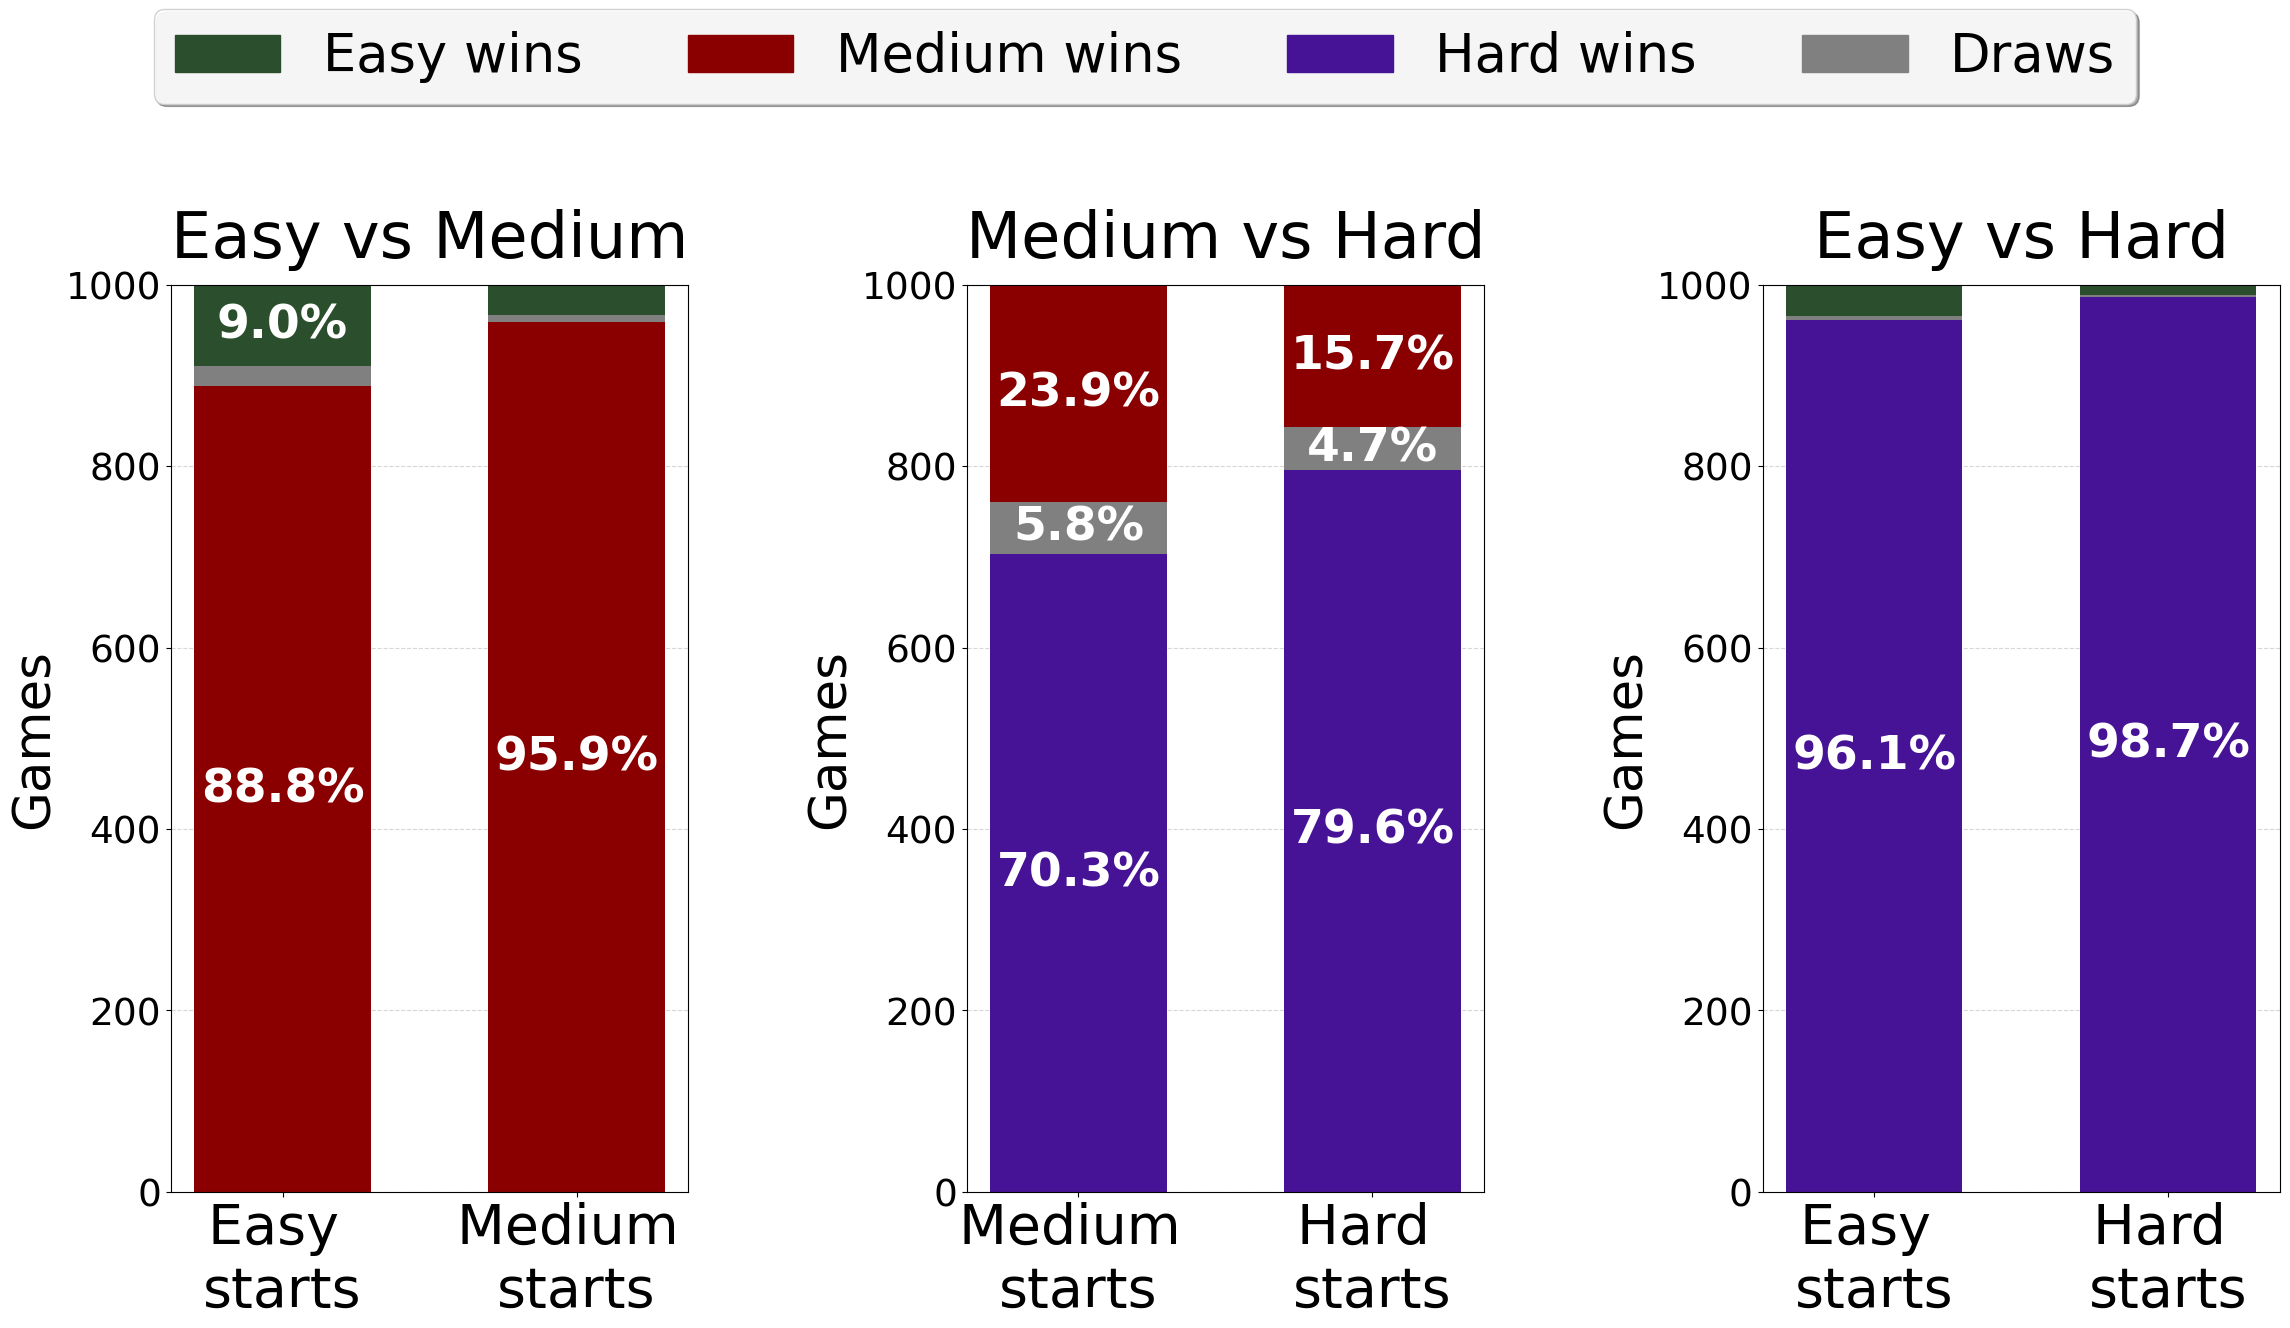

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Define the matchups to display
pairs = [
    ("Easy", "Medium"),
    ("Medium", "Hard"),
    ("Easy", "Hard")
]

level_to_color = {
    "Easy" : '#2B4F2D',
    "Medium" : '#8A0000', 
    "Hard" : '#471396',
}

# Set up the plotting area
fig, axes = plt.subplots(1, 3, figsize=(23, 15))

bar_width = 0.6

percent = lambda val: f"{round((val / n_games) * 100, 3)}%"


for ax, (p1, p2) in zip(axes, pairs):
    ax.set_axisbelow(True)


    # Game 1: P1 = p1, P2 = p2
    data1 = statistics[p1][p2]
    p1_wins_1 = data1["P1 won"]
    p2_wins_1 = data1["P2 won"]
    draws_1 = data1["Draw"]

    # Game 2: P1 = p2, P2 = p1
    data2 = statistics[p2][p1]
    p1_wins_2 = data2["P1 won"]
    p2_wins_2 = data2["P2 won"]
    draws_2 = data2["Draw"]

    # Bar positions
    x_labels = [f"{p1} \nstarts", f"{p2} \nstarts"]
    x = range(len(x_labels))

    # Prepare values: Each stack has bars for P1, Draw, P2
    bars_p1 = [p1_wins_1, p2_wins_2]
    bars_draw = [draws_1, draws_2]
    bars_p2 = [p2_wins_1, p1_wins_2]

    # Difficulty colors
    p1_color = level_to_color[p1]
    p2_color = level_to_color[p2]

    min_display_height = 40  # Minimum height in data units to display text

    for j in range(2):
        # P2 wins (bottom)
        p2_height = bars_p2[j]
        if p2_height > 0:
            ax.bar(x[j], p2_height, color=p2_color, width=bar_width)
            if p2_height >= min_display_height:
                ax.text(
                    x[j], p2_height / 2, percent(p2_height),
                    ha='center', va='center', fontsize=34, color='white', fontweight='bold',
                )

        # Draws (middle)
        draw_height = bars_draw[j]
        if draw_height > 0:
            ax.bar(x[j], draw_height, bottom=p2_height, color='gray', width=bar_width)
            if draw_height >= min_display_height:
                ax.text(
                    x[j], p2_height + draw_height / 2, percent(draw_height),
                    ha='center', va='center', fontsize=34, color='white', fontweight='bold',
                )

        # P1 wins (top)
        p1_height = bars_p1[j]
        if p1_height > 0:
            ax.bar(x[j], p1_height, bottom=p2_height + draw_height, color=p1_color, width=bar_width)
            if p1_height >= min_display_height:
                ax.text(
                    x[j], p2_height + draw_height + p1_height / 2, percent(p1_height),
                    ha='center', va='center', fontsize=34, color='white', fontweight='bold',
                )



    # Formatting
    ax.set_title(f"{p1} vs {p2}", fontsize=46, pad=20)
    ax.set_xticks(x,)
    ax.set_xticklabels(x_labels, fontsize=40)
    ax.set_ylim(0, n_games)
    ax.set_ylabel("Games", fontsize=37)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='y', labelsize=27)

# Create global legend with all colors used
legend_patches = [
    mpatches.Patch(color=color, label=f"{level} wins")
    for level, color in level_to_color.items()
]
legend_patches.append(mpatches.Patch(color='gray', label='Draws'))

fig.legend(handles=legend_patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.9), fontsize=38, fancybox=True, framealpha=0.9, shadow=True)


plt.tight_layout(rect=[0, 0, 1, 0.76], w_pad=8.0)

plt.show()

In [ ]:
fig.savefig('figures/bot_vs_bot.pdf')

### MCS vs MCTS at n_iterations = 10_000

In [ ]:
n_iterations = 10_000

vs_dict = {
    'mcs' : lambda board : mcs_play(board, n_iterations),
    'mcts' : lambda board : mcts_play(board, n_iterations, 1.414)
}

In [ ]:
mcs_vs_mcts_stats = get_statistics(20, vs_dict, 20)

Number of games simulated per match: 20
Player 1: mcs     Player 2: mcts
 0  1  2  3  4  5  6 
                     
                     
                     
                     
                     
          2          
 0  1  2  3  4  5  6 
 0  1  2  3  4  5  6 
                     
                     
                     
                     
                     
          2  1       
 0  1  2  3  4  5  6 
 0  1  2  3  4  5  6 
                     
                     
                     
                     
          2          
          2  1       
 0  1  2  3  4  5  6 
 0  1  2  3  4  5  6 
                     
                     
                     
          1          
          2          
          2  1       
 0  1  2  3  4  5  6 
 0  1  2  3  4  5  6 
                     
                     
                     
          1          
          2  2       
          2  1       
 0  1  2  3  4  5  6 
 0  1  2  3  4  5  6 
                     
   

In [ ]:
print(json.dumps(mcs_vs_mcts_stats, indent=2))

{
  "mcs": {
    "mcts": {
      "P1 won": 1,
      "P2 won": 18,
      "Draw": 1
    }
  },
  "mcts": {
    "mcs": {
      "P1 won": 20,
      "P2 won": 0,
      "Draw": 0
    }
  }
}
